In [39]:
import numpy as np
from scipy.special import erf, erfc
from scipy.optimize import root, curve_fit
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150

In [40]:
Tm      = 54.        # *C
Tw      = 120.        # *C
dT      = 20.        # *C
T1      = 30.        # *C
L       = 2.1e5      # J/kg
rho_l   = 780.       # kg/m^3
rho_s   = 860.       # kg/m^3
lam_l   = 0.15       # W/K m
lam_s   = 0.24       # W/K m
c_l     = 2100.      # J/kg K
c_s     = 2900.      # J/kg K

a_s = lam_s / (rho_s * c_s)
a_l = lam_l / (rho_l * c_l)

### Analytisch k

(np.float64(0.4081365927393771), np.float64(-2.220446049250313e-16))

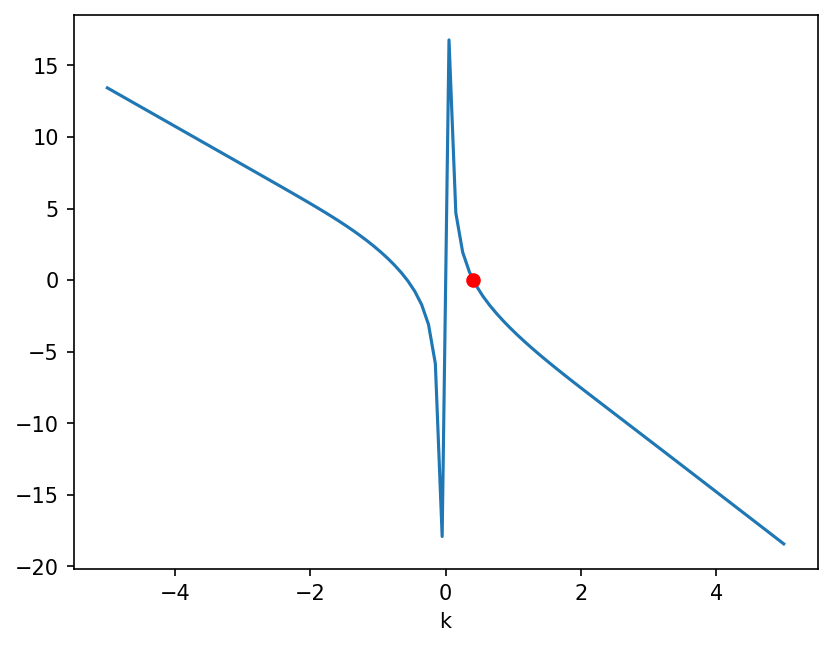

In [41]:
root_function = lambda k: np.exp(-k**2) / erf(k) \
    + lam_s / lam_l * np.sqrt(a_l / a_s) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) \
    - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

ki = np.linspace(-5, 5, 100)
k = root(root_function, 2)["x"][0]

plt.plot(ki, root_function(ki))
plt.plot(k, root_function(k), 'ro')
plt.xlabel("k")
k, root_function(k)

In [42]:
w       = 50e-3
dx      = 1e-4       # m
dt      = 1e-4       # s

x = np.arange(0, w, dx) # all cell positions
t1 = 3600. # simulation time to run for
N = int(t1 / dt) # number of iterations for simulation time

playback = t1 / 30 # playback speed
fps = 20 # fps for animation
t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps * playback) == 0)[0] # all iterations that are displayed

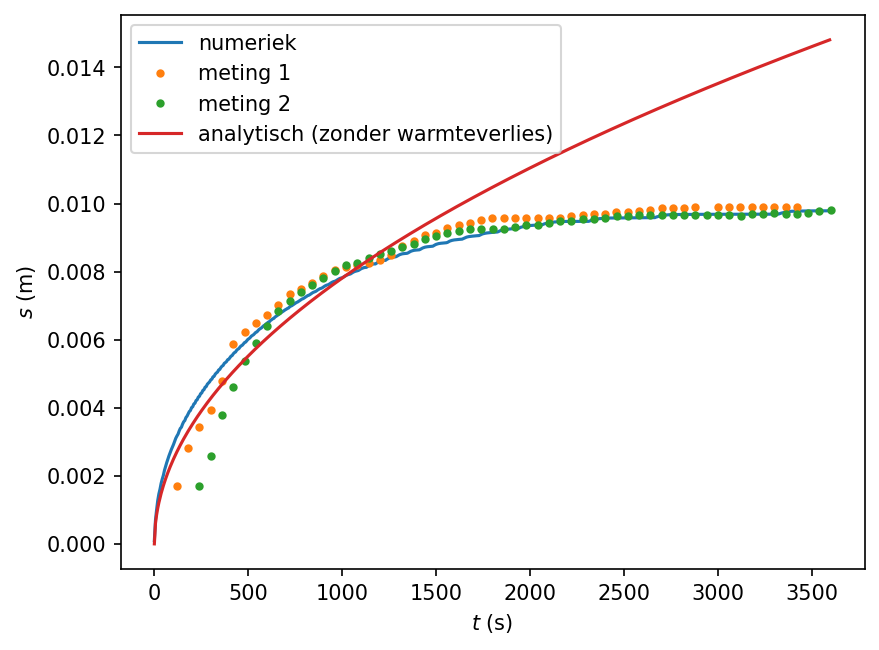

In [44]:
T = np.loadtxt("returnsT0=120.0,dT=0.5.csv", delimiter=',')
_, t_exp1, s_exp1 = np.loadtxt("VID2_20250702_121653112.csv", delimiter=',', skiprows=1).T
_, t_exp2, s_exp2 = np.loadtxt("VID2_20250702_141248613.csv", delimiter=',', skiprows=1).T

s_exp1 /= 1e3
s_exp2 /= 1e3

s = [x[np.abs(T[0] - Tm).argmin()]]
for i in range(1, len(frames)):
    index_min = np.abs(T[i] - Tm).argmin()
    if T[i][index_min] < Tm:
        s.append(x[index_min] + (Tm - T[i][index_min]) / (T[i][index_min + 1] - T[i][index_min]) * dx)
    if T[i][index_min] > Tm:
        s.append(x[index_min] - (Tm - T[i][index_min]) / (T[i][index_min - 1] - T[i][index_min]) * dx)
        # s.append(x[index_min] - (Tm - T[i][index_min - 1] - T[i][index_min]) / (T[i][index_min] - T[i][index_min - 1]) * dx)

t = frames * dt

plt.plot(t, s, label="numeriek")
plt.plot(t_exp1[t_exp1 < t1], s_exp1[t_exp1 < t1]+1.7e-3, '.', label="meting 1")
plt.plot(t_exp2[t_exp2 < t1], s_exp2[t_exp2 < t1]+1.7e-3, '.', label="meting 2")
plt.plot(t, 2 * k * np.sqrt(a_l * t), label="analytisch (zonder warmteverlies)")
plt.xlabel("$t$ (s)")
plt.ylabel("$s$ (m)")
plt.legend(loc="upper left")